In [1]:
from lib.datasets import Dataset2p0
from torch.utils.data import DataLoader,TensorDataset
import matplotlib.pyplot as plt

data_dir = f'w501_centered_tiny_x'
trainloader = DataLoader(Dataset2p0(dir=f'{data_dir}/train/',labels=f'{data_dir}/y_train.pt'),batch_size=64,shuffle=True)
devloader = DataLoader(Dataset2p0(dir=f'{data_dir}/dev/',labels=f'{data_dir}/y_test.pt'),batch_size=64,shuffle=True)
testloader = DataLoader(Dataset2p0(dir=f'{data_dir}/test/',labels=f'{data_dir}/y_test.pt'),batch_size=64,shuffle=True)

/home/andrew/.local/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from torch import nn
import torch
from torch.nn.functional import relu
from tqdm import tqdm

device = 'cuda'
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.c1 = nn.Conv1d(in_channels=1,out_channels=16,kernel_size=8,stride=1,padding='same',bias=False)
        self.bn1 = nn.BatchNorm1d(num_features=16)
        self.gap = nn.AvgPool1d(kernel_size=501)

        self.fc1 = nn.Linear(16,4)
        self.fc2 = nn.Linear(4,1)
    
    def forward(self, x):
        x = x.view(-1,1,501)
        x = self.c1(x)
        x = self.bn1(x)
        x = relu(x)
        x = self.gap(x)
        
        x = self.fc1(x.squeeze(2))
        x = relu(x)
        x = self.fc2(x)

        return x  
model = MLP().to(device=device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters())
params = sum([p.flatten().size()[0] for p in list(model.parameters())])
print("Params: ",params)

Params:  233


In [3]:
X,y = next(iter(trainloader))

In [4]:
model(X.cuda()).shape

/home/andrew/.local/lib/python3.10/site-packages/torch/nn/modules/conv.py:309: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at ../aten/src/ATen/native/Convolution.cpp:895.)
  return F.conv1d(input, weight, bias, self.stride,


torch.Size([64, 1])

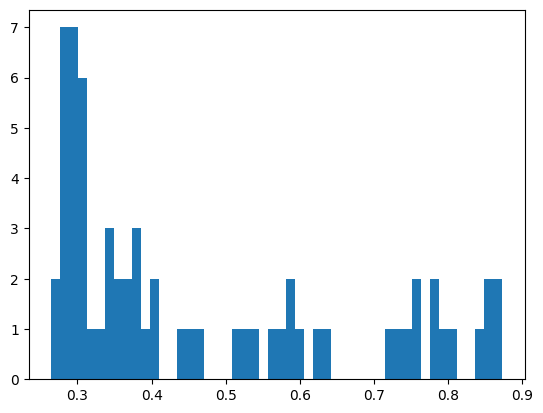

In [5]:
plt.hist(model(X.cuda()).flatten().detach().cpu(),bins=50);

100%|██████████| 3075/3075 [00:20<00:00, 148.34it/s]


tensor(0.1749)


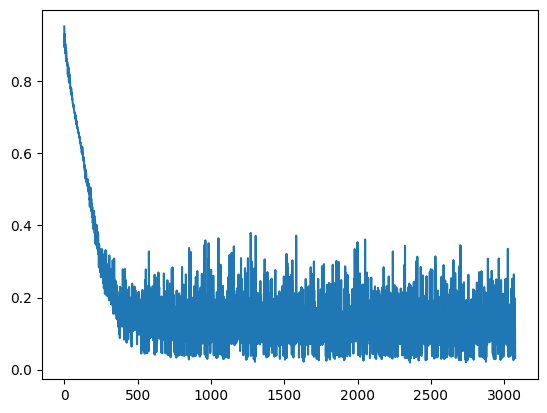

In [6]:
from tqdm import tqdm
lossi = []
model.train()

for i in range(1):
    for (X_tr,y_tr) in tqdm(trainloader):
        X_tr,y_tr = X_tr.to(device),y_tr.to(device)
        logits = model(X_tr)
        loss = criterion(logits,y_tr)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        lossi.append(loss.item())
plt.plot(lossi)
print(torch.tensor(lossi).mean())

tensor(0.1321)


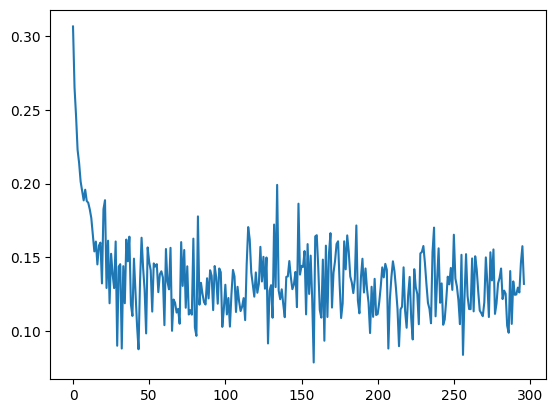

In [7]:
plt.plot(torch.tensor(lossi[100:len(lossi) - len(lossi)%10]).view(-1,10).mean(axis=1))
print(torch.tensor(lossi[100:len(lossi) - len(lossi)%10]).view(-1,10).mean(axis=1)[-1])

In [17]:
loss_tr = []
loss_dev = []

In [21]:
pbar = tqdm(range(5))

for epoch in pbar:
    # train loop
    model.train()
    loss_tr_total = 0
    for (X_tr,y_tr) in trainloader:
        X_tr,y_tr = X_tr.to(device),y_tr.to(device)
        logits = model(X_tr)
        loss = criterion(logits,y_tr)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_tr_total += loss.item()
    loss_tr.append(loss_tr_total/len(trainloader))

    # dev loop
    model.eval()
    loss_dev_total = 0
    for (X_dv,y_dv) in devloader:
        X_dv,y_dv = X_dv.to(device),y_dv.to(device)
        logits = model(X_dv)
        loss = criterion(logits,y_dv)
        loss_dev_total += loss.item()
    loss_dev.append(loss_dev_total/len(devloader))

100%|██████████| 5/5 [00:50<00:00, 10.09s/it]


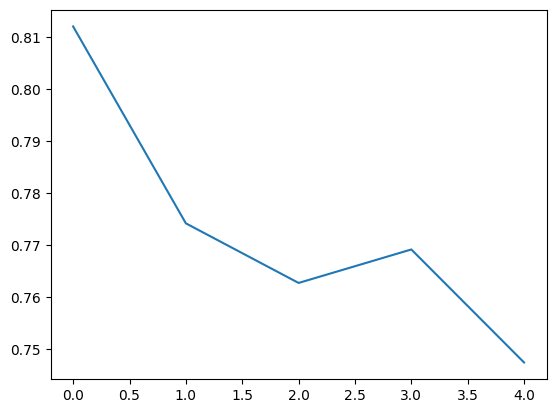

In [23]:
plt.plot(loss_tr)
# plt.plot(loss_dev)

In [7]:
from tqdm import tqdm
y_true = torch.Tensor()
y_pred = torch.Tensor()
model_was_training = False
if(model.training):
    # note that this changes the state of the model outside the scope of this function
    model_was_training = True
    model.eval()

In [15]:

loss_dev_total = 0
for (X,y) in tqdm(trainloader):
    X,y = X.to(device),y.to(device)
    logits = model(X)
    loss = criterion(logits,y)
    loss_dev_total += loss.item()
    y_true = torch.cat([y_true,y.detach().cpu()])


100%|██████████| 3075/3075 [00:17<00:00, 171.32it/s]


In [ ]:

        y_pred = torch.cat([y_pred,torch.sigmoid(logits).detach().cpu()])
    y_true = y_true
    y_pred = y_pred

In [7]:
from lib.utils import test_evaluation
loss,y_true,y_pred = test_evaluation(trainloader,model,criterion)

 44%|████▍     | 1349/3075 [00:08<00:10, 161.87it/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 20.00 MiB (GPU 0; 7.78 GiB total capacity; 5.44 GiB already allocated; 32.00 MiB free; 5.44 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF